## Plan-and-Execute

This notebook shows how to create a "plan-and-execute" style agent. This is heavily inspired by the Plan-and-Solve paper (https://arxiv.org/abs/2305.04091) as well as the Baby-AGI project (https://github.com/yoheinakajima/babyagi).
The core idea is to first come up with a multi-step plan, and then go through that plan one item at a time. After accomplishing a particular task, you can then revisit the plan and modify as appropriate.

This compares to a typical ReAct style agent where you think one step at a time. The advantages of this "plan-and-execute" style agent are:

1. Explicit long term planning (which even really strong LLMs can struggle with)
2. Ability to use smaller/weaker models for the execution step, only using larger/better models for the planning step

https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/#re-plan-step


### 1. Define tools, execution Agent

we will create the execution agent we want to use to execute tasks. Note that for this example, we will be using the same execution agent for each task, but this doesn't HAVE to be the case.


In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent
import os
from dotenv import load_dotenv

load_dotenv()

system_prompt = """You are a helpful assistant that can search the web for information.
You will be provided with a search query, and you should return the top 3 results from Tavily.
"""

llm = AzureChatOpenAI(
    model=os.getenv("AZURE_OPENAI_MODEL"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    openai_api_type='azure'
)

print(llm)
tools = [TavilySearchResults(max_results=3)]
agent_executor = create_react_agent(llm, tools, state_modifier=system_prompt)


client=<openai.resources.chat.completions.completions.Completions object at 0x0000021F5B791400> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000021F5B79D010> root_client=<openai.lib.azure.AzureOpenAI object at 0x0000021F5B56BA10> root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x0000021F5B791550> model_name='gpt-4o' model_kwargs={} openai_api_key=SecretStr('**********') azure_endpoint='https://ai-hubeastus625397087436.openai.azure.com/' openai_api_version='2025-01-01-preview' openai_api_type='azure'


In [2]:
agent_executor.invoke({"messages": [("user", "Should we invest in Tesla given the current situation of EV?")]})

{'messages': [HumanMessage(content='Should we invest in Tesla given the current situation of EV?', additional_kwargs={}, response_metadata={}, id='f649081e-3e13-489c-a672-1ba90248731e'),
  AIMessage(content="To make an informed decision about investing in Tesla amidst the current situation of the electric vehicle (EV) market, it is important to consider several factors, including the company's financial performance, market trends, competition, and technological advancements.\n\nSince investment decisions require up-to-date and comprehensive analysis, I will search for the latest information related to Tesla and the EV market. Please hold on.", additional_kwargs={'tool_calls': [{'id': 'call_zeMlnHhOqGujyGy7z9Hcz4TL', 'function': {'arguments': '{"query":"current situation of Tesla in EV market October 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 126, 'total_tokens': 23

### 2. State Management

Now, let’s take a look how our agent keeps track of everything it needs to do. Think of it like a smart to-do list system with three main parts.

1. First, we need a way to track what the agent plans to do. We’ll use a simple list of steps written as text strings. This is like having a checklist of tasks the agent needs to complete.
2. Second, we want to remember what it has already done and what happened with each task. For this, we’ll use a list of pairs (or tuples in programming terms). Each pair contains both the action taken and what resulted from that action.
3. Lastly, we need to store two more important pieces of information: the original question that was asked (the input) and the final answer once the agent finishes its work (the response).

This setup gives our agent everything it needs to function effectively.
the PlanExecute class, a dictionary type, manages an execution process, including input, plan steps, previous steps, and a response. The Plan class, using Pydantic, defines a structured plan with steps that should be followed in a sorted order.


In [3]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [4]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

### 3. The Planning Step

The planning step is where our agent will begin to tackle a research question. We’ll use a special feature called function calling to create this plan. Let’s break down how it works.

First, we create a template for how our agent should think. We tell it that it’s a finance research agent working in October 2024, and its job is to break down big questions into
smaller, manageable steps.This template, called **planner_prompt** as below, gives our agent clear instructions:
create a simple, step-by-step plan where each step leads logically to the next. Ensure that no steps are missing or unnecessary. The final step should give us our answer.

The code sets this up by using **ChatPromptTemplate**, which has two main parts:

1. A system message that explains the agent’s role and how it should plan
2. A placeholder for the messages we’ll send it


In [5]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a finance research agent working in Oct 2024. For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps. \
At the end use the info collected to give the final answer to the main question containing the facts.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)


We then connect this template to AzureChatOpenAI using gpt-4o with temperature set to 0 for consistent results. The “structured output” part means the plan will come out in a specific format we can easily work with. When we test it with a real question like “Should we invest in Tesla given the current situation of EVs?” the agent will create a detailed plan for researching this investment decision. Each step will help gather the information needed to make an informed recommendation about Tesla stock based on the current electric vehicle market conditions.

Think of it like creating a research roadmap. We’re giving our agent the tools and guidelines it needs to break down complex questions into manageable research tasks.


In [6]:
planner.invoke(  
    {  
        "messages": [  
            ("user", "Should we invest in Tesla given the current situation of EV?")  
        ]  
    }  
)  

Plan(steps=["Gather recent data on Tesla's stock performance and financial metrics, including revenue, profitability, and market share, as of October 2024.", 'Analyze the recent news related to Tesla, focusing on any major developments such as new product launches, partnerships, or regulatory changes affecting the EV industry.', 'Review the overall economic situation and market trends for the EV industry, including consumer demand, governmental policies, and technological advancements as of October 2024.', "Compare Tesla's performance and strategic position with its major competitors in the EV industry, like Rivian, Lucid, or traditional automakers transitioning to EVs such as General Motors and Ford.", "Evaluate analyst reports and investor sentiment concerning Tesla's future prospects and potential risks, ensuring these reports are up-to-date with October 2024 information.", "Assess Tesla's ability to overcome current and future challenges in the industry, such as battery technology,

### 4. Replanning Step

Think of re-planning as the agent’s ability to adjust its strategy based on what it has already learned. This is similar to how we might revise our research approach after discovering new information. Let’s break down how this works.

First, we create two types of possible actions the agent can take:

1. Response: When the agent has enough information to answer the user’s question
2. Plan: When the agent needs to do more research to get a complete answer

The re-planning prompt is like giving our agent a structured way to think about what to do next. It looks at three things:

1. The original question (objective)
2. The initial plan it made
3. What steps have already been completed and what was learned

Using this information, the agent can decide to either:

1. Create new steps to gather more needed information
2. Give a final answer if it has enough information

The clever part is that the agent won’t repeat steps it’s already done. It focuses only on what still needs to be investigated. This makes the research process more efficient and prevents redundant work. It’s like having a research assistant who can intelligently adjust their approach based on what they’ve already discovered. This process helps our agent stay focused and efficient, only pursuing new information when needed and knowing when it’s time to provide a final answer to the user.

We connect this re-planning ability to gpt-4o with the temperature set to 0. By setting the temperature to 0, we force the model to generate the same response for the same input. This helps us in making experiments reproducible.


In [7]:
from typing import Union

class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | llm.with_structured_output(Act)

### 5. Create the graph by Defining nodes

Think of this graph as a roadmap that shows how our agent moves from one task to another. We have three main functions that work together:
The **execute_step** function handles individual tasks. It takes the first item from our plan, formats it properly, and has the agent work on it. It’s like giving a specific assignment to a research assistant and getting back their findings. The agent keeps track of what it did and what it learned.
The **plan_step** function is where everything begins. When given a question, it creates the initial research plan. This is like creating a first draft of how to tackle the problem.
The **replan_step** function is where the agent decides what to do next. After completing a task, it looks at what it has learned and either:

1. Creates new steps if more research is needed
2. Provides a final answer if it has enough information

Finally, we have the **should_end** function, which works like a checkpoint. It checks whether we have a final answer ready. If we do, it ends the process. If not, it tells the agent to continue working. You can see all these functions in the code snippet below.


In [8]:
from typing import Literal
from langgraph.graph import END

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

#### 5.1 Create workflow

We use StateGraph to create a map that guides our agent through its research journey via different actions it can take. Here’s how it flows:
First, we create the basic structure of the workflow with its three main stops:

1. A planning station (“planner”)
2. A research station (“agent”)
3. A reviewing station (“replan”)

Then, we connect these stations in a logical order:

1. Everything starts at the planning station
2. From planning, the agent moves to doing research
3. After research, it goes to reviewing what it learned

At the reviewing station, the agent makes an important decision:

1.  Either continue with more research if needed
2.  Or finish up if it has a complete answer

This creates a smooth cycle in which the agent can continue researching until it has everything it needs to answer the original question. It’s like having an intelligent research assistant who knows when to dig deeper and when they’ve found enough information.

Finally, we compile this workflow into something we can easily use, just like any other tool in our system. This makes our research agent ready to tackle real questions and provide thorough, well-researched answers.


In [9]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

#### 5.2 Visualize agent workflow

We can visualize the agent workflow with a mermaid chart


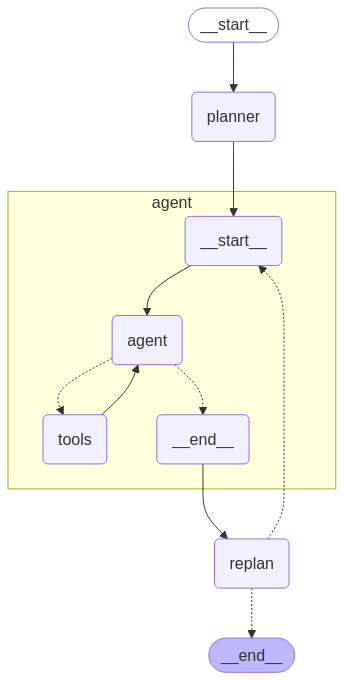

In [10]:
# %pip install IPython

from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### 6. Run the plan-and-execute agent


In [11]:
config = {"recursion_limit": 50}
inputs = {"input": "Should we invest in Tesla given the current situation of EV?"}
# inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Research the current state of the Electric Vehicle (EV) market, focusing on major trends, growth projections, and challenges as of October 2024.', "Analyze Tesla's recent financial performance. Gather data on their revenue, profits, stock performance, and any recent earnings calls or financial statements.", "Examine Tesla's market position within the EV industry. Identify their market share, competitive advantages, and any recent developments related to their technology or product offerings.", "Identify key regulatory changes or government incentives related to EVs that could potentially impact Tesla's operations positively or negatively.", 'Assess the broader economic context, including interest rates, inflation, and consumer spending trends that could affect the automotive and EV sectors.', 'Research analyst opinions and market sentiment about Tesla and the EV industry, including target stock prices and investment ratings from reputable financial institutions.', 'Compile t

CancelledError: 

### Conclusion

One known limitations of the above design is that each task is still executed in sequence, meaning embarrassingly parallel operations all add to the total execution time. You could improve on this by having each task represented as a DAG (similar to LLMCompiler), rather than a regular list.


### Optional: Create the LLM Judge

Example - https://www.galileo.ai/blog/llm-as-a-judge-vs-human-evaluation

Create a LLM judge to evaluate our agent’s performance. This ensures our agents’ responses adhere to the given context and maintain relevance and accuracy.
The inbuilt scorers make it very easy to set up one for us. We use gpt-4o as our LLM for the context adherence metric, with three evaluations per response for better to ensure great evaluation accuracy. This scorer specifically looks at how well the agent sticks to the context and provides relevant information. Note that we’re using GPT-4o to evaluate a smaller AI model, which is like having an expert oversee a novice’s work. GPT-4o, with its advanced capabilities and deep understanding of language nuances, can be a reliable benchmark for judging the smaller model’s (in our case, the 4o-mini) responses.
